In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize, integrate
from mcmc_utils_and_plot import scatter_matrix 

# Estimating time-varying system parameter using particle MCMC

Sibo Wang 
December, 2022

## Reference system

$\theta = \{S_0, E_0, I_0, R_0, c_0, \sigma, k, \gamma\} = \{840, 5, 5, 150, 3.5, \sigma, 3, 1.5\}$

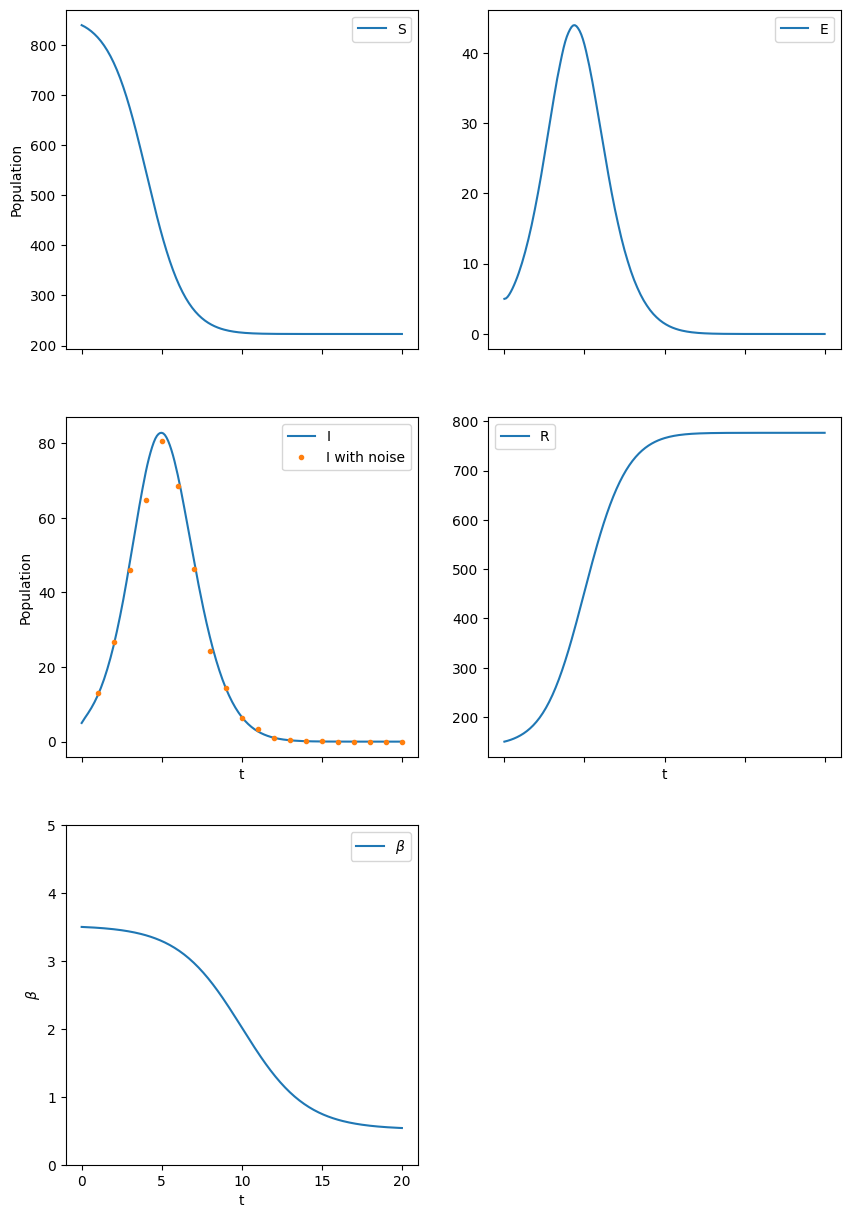

In [2]:
class ReferenceSimulation(): 
    def __init__(self, seed = None, y0 = [840, 5, 5, 150, 3.5, 3, 1.5]):
        # S E I R
        self.y0 = y0[0:5]
        self.tspan = [0,20]
        self.t = np.linspace(0, 20, 201)

        self.seed = seed
        self.meas_std = 0.1

        self.N = 1000
        self.k = y0[5] 
        self.gam = y0[6] 

        self.system_states = None
        self.noise = None
        self.data = None

    def ivp_func(self, t, y): 
        St = y[0]
        Et = y[1]
        It = y[2]
        Rt = y[3]
        bt = y[4]
        dS = - bt * St * It / self.N
        dE = bt * St * It / self.N - Et * self.k 
        dI = Et * self.k - It * self.gam
        dR = It * self.gam
        db = -(1.5 * np.exp(-0.5*(t-10))) / (np.power(1 + np.exp(-0.5*(t-10)), 2))
        # db = 0

        return [dS, dE, dI, dR, db]
     
    def solve_system(self): 
        sol = integrate.solve_ivp(self.ivp_func, self.tspan, self.y0, method="RK45", t_eval=self.t)
        self.system_states = sol.y
        return sol.t, sol.y
    
    def generate_data(self): 
        self.solve_system()

        rng = np.random.default_rng(seed=self.seed)
        self.noise = self.meas_std * rng.normal(size = 20)

        self.data = np.exp(np.log(self.system_states[2, 0::10][1:]) + self.noise)
        # self.data = self.system_states[2, 0::10][1:] + self.noise

        return self.t, self.data
    
    def plot_system_state(self, state_samples=None): 
        fig, ax = plt.subplots(3,2,figsize=(10,15), sharex='all')
        if (state_samples is not None):
            for state_sample in state_samples:
                self.plot_system_state_separate(t, state_sample, ax)

        ax[0,0].plot(self.t, self.system_states[0, :], label="S")
        ax[0,1].plot(self.t, self.system_states[1, :], label="E")
        ax[1,0].plot(self.t, self.system_states[2, :], label="I")
        ax[1,0].plot(self.t[0::10][1:], self.data, '.', label="I with noise")
        ax[1,1].plot(self.t, self.system_states[3, :], label="R")
        ax[2,0].plot(self.t, self.system_states[4, :], label=r"$\beta$")
        ax[0,0].legend()
        ax[0,1].legend()
        ax[1,0].legend()
        ax[1,1].legend()
        ax[2,0].legend()
        ax[2,0].set_ylim(0,5)
        ax[1, 0].set_xlabel("t")
        ax[1, 1].set_xlabel("t")
        ax[2, 0].set_xlabel("t")
        ax[0, 0].set_ylabel("Population")
        ax[1, 0].set_ylabel("Population")
        ax[2, 0].set_ylabel(r"$\beta$")
        ax[2, 1].axis('off')

    def plot_system_state_separate(self, t, system_data, ax): 
        ax[0,0].plot(t, system_data[0, :], color='grey', alpha=0.01)
        ax[0,1].plot(t, system_data[1, :], color='grey', alpha=0.01)
        ax[1,0].plot(t, system_data[2, :], color='grey', alpha=0.01)
        ax[1,1].plot(t, system_data[3, :], color='grey', alpha=0.01)
        ax[2,0].plot(t, np.exp(system_data[4, :]), color='grey', alpha=0.01)


reference = ReferenceSimulation(seed=2018)
t, data = reference.generate_data()
reference.plot_system_state()

## PMCMC setup
### Adaptive MCMC

In [3]:
class PMCMC: 
    '''
    Partilce MCMC
    Use particle filter to sample X_{1:T} based on new params and compute lopdf_proposed P(Y_{1:t} | params)

    Accept or reject new params based on Metrpolis-Hastings
    '''
    def __init__(self, mcmc_nsamples, nparticles, rwalk_cov, k0 = 50, s_d = 2.4 * 2.4 / 8, eps=1e-8):
        self.mcmc_nsamples = mcmc_nsamples
        self.nparticles = nparticles

        # === More setups for adaptive MCMC ===
        self.rwalk_cov = rwalk_cov
        self.cov_chol = np.linalg.cholesky(rwalk_cov)   # Gaussian random walk covariance
        self.k0 = k0
        self.s_d = s_d
        self.eps = eps

    
    def sample_mcmc(self, params_pdf_func, prior_params, 
                            particle_filter_sampler, 
                            data, meas_noise, 
                            T, dt):
        # === Assumptions ===
        # 1. Data is 1-dimensional and are avalaible iff t = 1, 2, 3, ...
        # 2. The total time T and step size dt are tuned such that t = 1, 2, 3, ... are included in time steps
        
        # === Initial setup ===
        
        t_vec = np.linspace(0, T, num=int(T/dt)+1)
        nsteps = t_vec.shape[0]

        def states_pdf_func(p_params):
            return particle_filter_sampler(p_params, data, meas_noise, t_vec, self.nparticles)

        # === n = 0 (intial sample of params) ===
        # Calculate the pdf of prior params, and run particle filter to sample conditioned system states and get its pdf
        params_logpdf = params_pdf_func(prior_params)
        states_logpdf, system_state_init_sample = states_pdf_func(prior_params)

        self.dim_params = prior_params.shape[0]                 # dimension of parameters
        self.dim_states = system_state_init_sample.shape[0]      # dimension of states

        self.params_samples = np.zeros((self.mcmc_nsamples, self.dim_params))
        self.system_state_samples = np.zeros((self.mcmc_nsamples, self.dim_states, nsteps))

        self.params_samples[0, :] = prior_params
        self.system_state_samples[0, :, :] = system_state_init_sample

        x_mean_prior = prior_params
        count_accept = 1
        count_samples = 1
        for n in range(1, self.mcmc_nsamples):
            proposed_params = self.params_samples[n-1, :] + np.dot(self.cov_chol, np.random.randn(self.dim_params))
            # Impose S + E + I + R = N
            proposed_params[0] = reference.N - proposed_params[1] - proposed_params[2] - proposed_params[3]
            proposed_params_logpdf = params_pdf_func(proposed_params)

            proposed_state_logpdf, proposed_system_state = states_pdf_func(proposed_params)

            # Determine acceptance probability
            # For the normal random walk proposal, q(x|y) = q(y|x). Thus a = min{fx(y)/fx(x), 1}
            a = np.exp(np.min((proposed_state_logpdf + proposed_params_logpdf - params_logpdf - states_logpdf, 0)))

            # Accept or reject 
            u = np.random.rand()
            if u < a: 
                self.system_state_samples[n, :, :] = proposed_system_state
                self.params_samples[n, :] = proposed_params
                states_logpdf = proposed_state_logpdf
                params_logpdf = proposed_params_logpdf
                count_accept += 1
            else: 
                self.system_state_samples[n, :, :] = self.system_state_samples[n-1, :, :]
                self.params_samples[n, :] = self.params_samples[n-1, :]
            count_samples += 1
            
            # Adapt covariance (Sigma)
            k = (count_samples - 1)
            cov_adapt, x_mean_prior = self.adapt_covariance(self.rwalk_cov, x_mean_prior, self.params_samples[n, :], k, self.s_d, self.eps)
            if  k >= self.k0: 
                self.rwalk_cov = cov_adapt
                self.cov_chol = np.linalg.cholesky(self.rwalk_cov)

            # Print progress at intervals
            if n % int(self.mcmc_nsamples / 10) == 0: 
                print(f"On sample {n}: Accepted samples ratio = {count_accept / count_samples}, states log like: {states_logpdf}")
            if n == self.mcmc_nsamples - 1:
                self.accept_ratio = count_accept / count_samples
        
    def adapt_covariance(self, S, x_mean_prior, x, k, s_d, eps):
        x_mean = 1.0 / (k + 1.0) * x + k / (k + 1.0) * x_mean_prior

        x_mean_prior_matrix = np.outer(x_mean_prior, x_mean_prior)
        x_mean_matrix = np.outer(x_mean, x_mean)
        x_matrix = np.outer(x, x)

        S = (k - 1.0) / k * S + s_d / k * (eps * np.eye(self.dim_params) + k * x_mean_prior_matrix - (k + 1) * x_mean_matrix + x_matrix)
        return S, x_mean



### Parameter distribution $P(\theta)$

In [4]:
def seir_params_pdf_func(params): 
    # params: {S_0, E_0, I_0, R_0, c_0, \sigma, k, \gamma}
    # S_0:      N - E0 - I0 - R0
    # E_0:      U(0, 10)
    # I_0:      U(0, 10)
    # R_0:      N(150, 10)
    # c_0:      U(-2, 2)
    # sigma:    U(0, 1)
    # k:        N(3, 0.5)
    # gamma:    N(1.5, 0.5)
    if (np.any(params[0:4]<0)): 
        return -1e9
    pdf_R = -0.5 * (params[3] - 150) ** 2 / 10
    pdf_k = -0.5 * (params[6] - reference.k) ** 2 / 0.5
    pdf_gamma = -0.5 * (params[7] - reference.gam) ** 2 / 0.5
    return pdf_R + pdf_k + pdf_gamma


### Measurement model $P(Y_k \mid X_k)$

In [5]:
def seir_measurement_pdf(state, data, meas_noise):
    log_sys_data = np.log(state[:, 2])
    log_data = np.log(data)
    residual = log_sys_data - log_data
    # residual = state[:, 2] - data
    # print(data)
    return -0.5 * np.power(residual, 2) / meas_noise
    

### Particle filter for $P(Y \mid \theta)$

In [6]:
# log likelihood of a given set of params based on particle filter
def seir_particle_filter_sampler(proposed_params, all_data, meas_noise, t_vec, nparticles):
    # params: {S_0, E_0, I_0, R_0, c_0, \sigma, k, \gamma}
    nsteps = t_vec.shape[0]
    dt = t_vec[1] - 0
    dim = 5

    samples = np.zeros((nparticles, dim, nsteps))
    weights = np.zeros((nparticles, nsteps))
    eff = np.zeros((nsteps))
    chosen_path = np.zeros((dim, nsteps))
    rr = np.arange(nparticles)          # For low-variance resampling
    
    samples[:, :, 0] = np.tile(proposed_params[0:5], (nparticles, 1))
    weights[:, 0] = 1.0 / nparticles    # all weights are equal because of independent sampling from prior
    eff[0] = nparticles
    chosen_path[:, 0] = samples[0, :, 0] # choose any, they are the same

    data_ii = 0
    loglike_cum = 0
    for ii, t in enumerate(t_vec):
        if ii == 0:
            continue
        
        # Propose based on system dynamics
        samples[:, :, ii] = seir_forward_euler(samples[:, :, ii-1], t, dt, proposed_params[5:])

        if (t % 1 == 0):
            # Update weights
            loglike = seir_measurement_pdf(samples[:, :, ii], all_data[data_ii], meas_noise) 
            # print("t = ", t, "loglike = ", np.max(loglike), np.min(loglike))

            if (np.min(loglike) < -400 or np.any(np.isnan(loglike))):
                loglike_cum = -1e9
                # print("\tparams: ", proposed_params, "\tt = ", t, "\tmin log like: ", np.min(loglike))
                break

            loglike_cum += np.log(np.mean(np.exp(loglike)))
            log_current_weights = loglike + np.log(weights[:, ii-1])

            weights[:, ii] = np.exp(log_current_weights) / np.sum(np.exp(log_current_weights))

            data_ii += 1
        else:
            weights[:, ii] = weights[:, ii-1]
        
        chosen_path[:, ii] = samples[np.random.choice(rr, p=weights[:, ii]), :, ii]
        
        eff[ii] = 1.0 / np.sum(weights[:, ii]**2)
        if eff[ii] < 0.5 * nparticles: 
            # Low variance resampling
            samp_inds = np.random.choice(rr, nparticles, p=weights[:, ii]) 
            samples[:, :, ii] = samples[samp_inds, :, ii]
            weights[:, ii] = np.ones((nparticles))/nparticles
        
    return loglike_cum, chosen_path


def seir_forward_euler(y, t, dt, proposed_params):
    # y: (nparticles, dim)
    N = reference.N
    sigma = proposed_params[0]
    k = proposed_params[1]
    gamma = proposed_params[2]
    
    St = y[:,0]
    Et = y[:,1]
    It = y[:,2]
    Rt = y[:,3]
    xt = y[:,4]
    bt = np.exp(xt)

    dS = - bt * St * It / N
    dE = bt * St * It / N - Et * k 
    dI = Et * k - It * gamma
    dR = It * gamma
    dx = sigma * np.sqrt(dt) * np.random.randn(y.shape[0])

    St = St + dS * dt
    Et = Et + dE * dt
    It = It + dI * dt
    Rt = Rt + dR * dt
    xt = xt + dx * dt

    return np.array([St, Et, It, Rt, xt]).T

### Result

In [7]:
# Reference: $\theta = \{S_0, E_0, I_0, R_0, c_0, \sigma, k, \gamma\} = \{840, 5, 5, 150, 3.5, \sigma, 3, 1.5\}$
# S_0:      N - E0 - I0 - R0
# E_0:      U(0, 10)
# I_0:      U(0, 10)
# R_0:      N(150, 10)
# c_0:      U(-2, 2)
# sigma:    U(0, 1)
# k:        N(3, 0.5)
# gamma:    N(1.5, 0.5)
# prior_params = np.array([840, 5, 5, 150, np.random.uniform(-2,2), np.random.uniform(0, 1), 3, 1.5])
prior_params = np.array([840, np.random.uniform(0,10), np.random.uniform(0,10), 150, np.random.uniform(-2,2), np.random.uniform(0, 1), 3, 1.5])
prior_params[0] = reference.N - prior_params[1] - prior_params[2] - prior_params[3]

# S_0, E_0, I_0, R_0, c_0, \sigma, k, \gamma
rwalk_cov = np.diag([1, 0.1, 0.1, 1, 0.05, 0.01, 0.005, 0.01])


pmcmc = PMCMC(mcmc_nsamples = 5000, nparticles = 1000, rwalk_cov = rwalk_cov, k0 = 500, s_d = 2.4 * 2.4 / 8, eps=1e-8)
pmcmc.sample_mcmc(params_pdf_func = seir_params_pdf_func, prior_params = prior_params, 
                            particle_filter_sampler = seir_particle_filter_sampler, 
                            data = reference.data, meas_noise = reference.meas_std**2, 
                            T=20, dt=0.1)

On sample 500: Accepted samples ratio = 0.2894211576846307, states log like: -22.48838210681411
On sample 1000: Accepted samples ratio = 0.29270729270729273, states log like: -26.518386717789244


C:\Users\Sybokia\AppData\Local\Temp\ipykernel_21752\4087969586.py:2: RuntimeWarning: invalid value encountered in log
  log_sys_data = np.log(state[:, 2])


On sample 1500: Accepted samples ratio = 0.29447035309793473, states log like: -21.861584755978473
On sample 2000: Accepted samples ratio = 0.28385807096451776, states log like: -23.644146550758997
On sample 2500: Accepted samples ratio = 0.2746901239504198, states log like: -21.203966222582217
On sample 3000: Accepted samples ratio = 0.263245584805065, states log like: -24.225937770185126
On sample 3500: Accepted samples ratio = 0.2582119394458726, states log like: -23.349210722401622
On sample 4000: Accepted samples ratio = 0.2516870782304424, states log like: -22.237948597749607
On sample 4500: Accepted samples ratio = 0.24705620973117084, states log like: -21.7231104679241


In [8]:
def sub_sample_data(samples, system_state_samples, frac_burn=0.2, frac_use=0.7):
    nsamples = samples.shape[0]
    inds = np.arange(nsamples, dtype=int)
    start = int(frac_burn * nsamples)
    inds = inds[start:]
    nsamples = nsamples - start
    step = int(nsamples / (nsamples * frac_use))
    inds2 = np.arange(0, nsamples, step)
    inds = inds[inds2]
    subsamples = samples[inds, :]
    system_state_samples = system_state_samples[inds, :, :]
    return subsamples, system_state_samples

sub_samples, sub_state_samples = sub_sample_data(pmcmc.params_samples, pmcmc.system_state_samples, frac_burn = 0.2, frac_use=0.7)

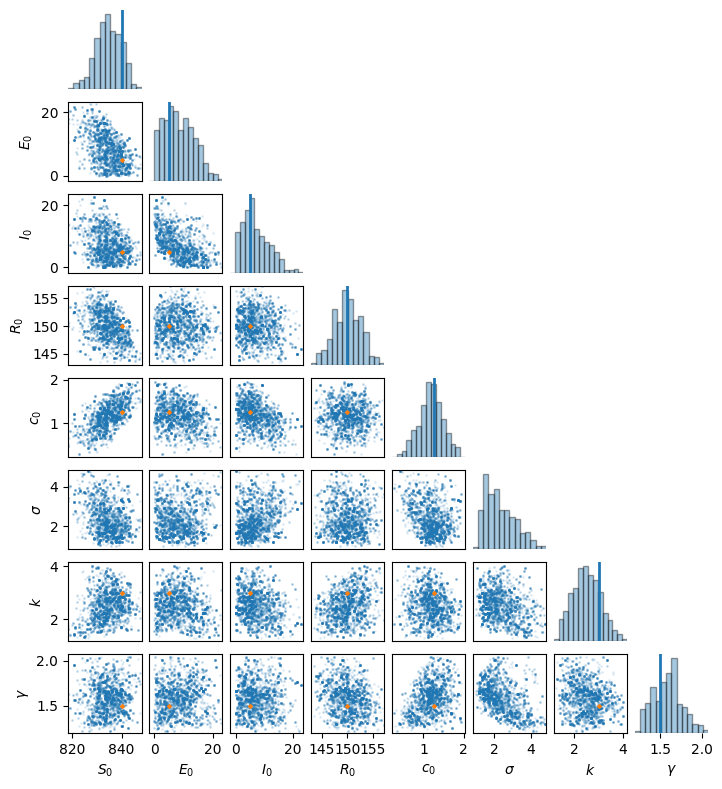

In [9]:
true_param = np.array([840, 5, 5, 150, np.log(3.5), np.random.uniform(0, 1), 3, 1.5])

def plot_identifiable_posterior(samples):
   fig, axs, gs = scatter_matrix([samples], #list of chains
                                   labels=[r"$S_0$", r"$E_0$", r"$I_0$", r"$R_0$", r"$c_0$", r"$\sigma$", r"$k$", r"$\gamma$"],
                                  hist_plot=False, # if false then only data
                                  gamma=0.1,
                                  specials={"vals":true_param}
                                  )
   fig.set_size_inches(8, 8)

plot_identifiable_posterior(sub_samples)

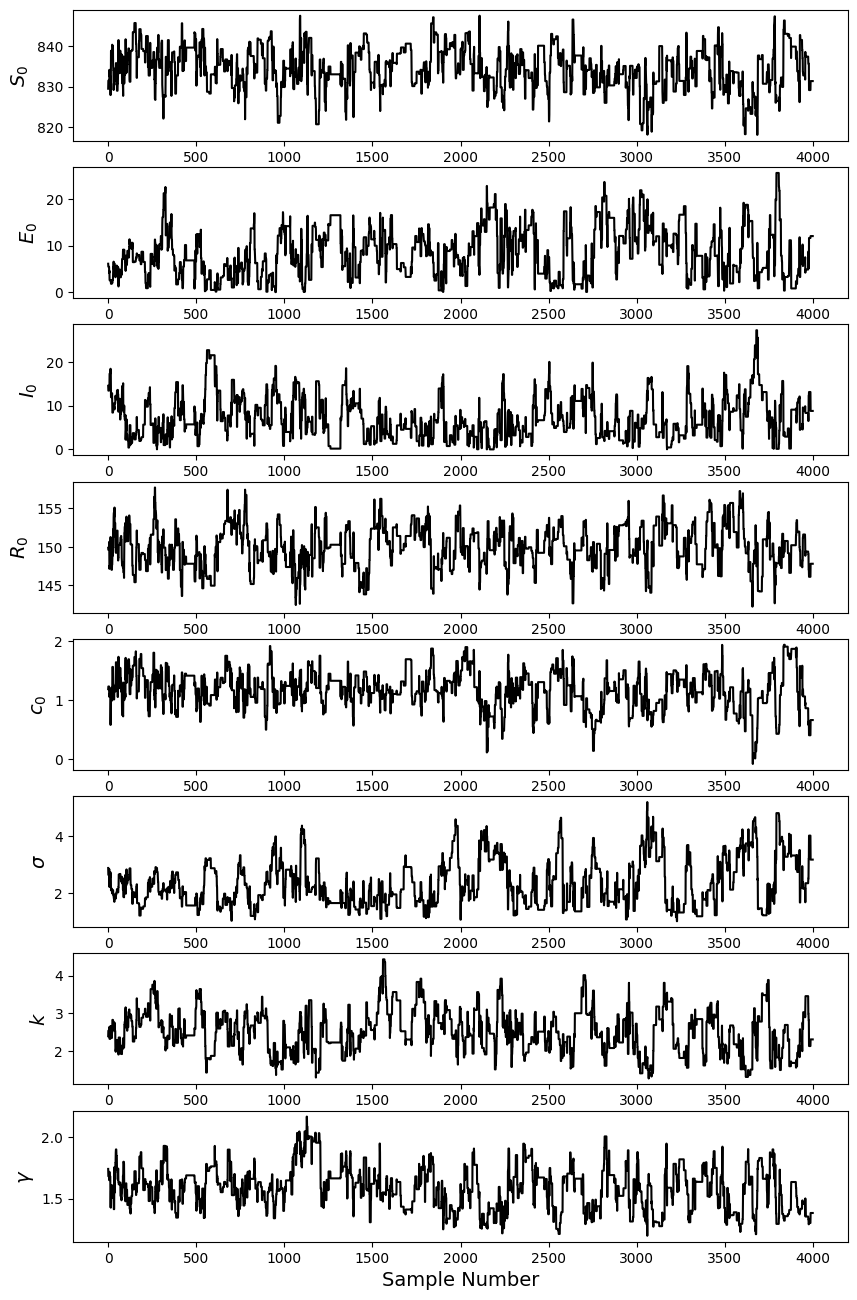

In [10]:
def plot_mixing(samples, labels=None):
    num_params = samples.shape[1]
    fig, axs = plt.subplots(num_params, 1, figsize=(10,2*num_params))
    for ii in range(num_params):
        axs[ii].plot(samples[:, ii], '-k')
        if labels == None:
            axs[ii].set_ylabel(f'$x_{ii+1}$', fontsize=14)
        else:
            axs[ii].set_ylabel(labels[ii], fontsize=14)
    axs[ii].set_xlabel('Sample Number', fontsize=14)

plot_mixing(sub_samples, labels=[r"$S_0$", r"$E_0$", r"$I_0$", r"$R_0$", r"$c_0$", r"$\sigma$", r"$k$", r"$\gamma$"])

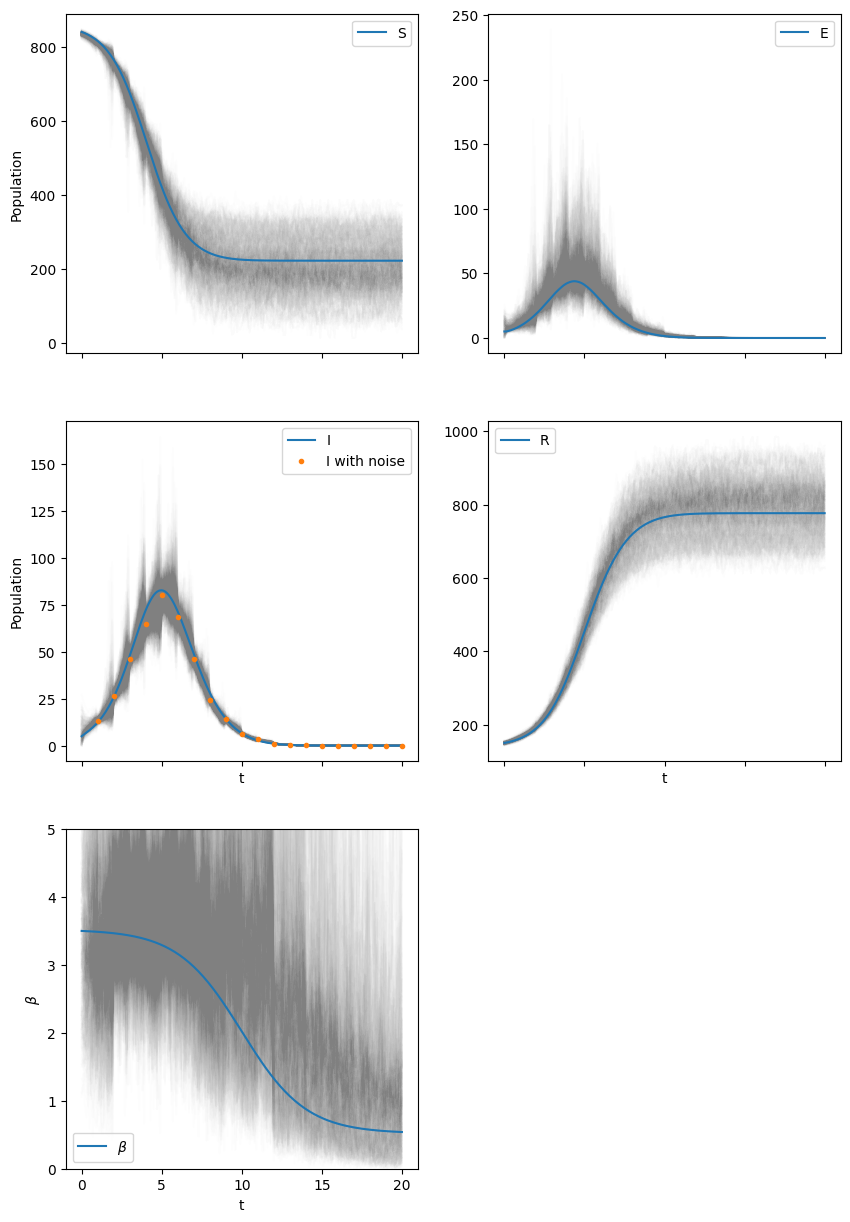

In [11]:
reference.plot_system_state(sub_state_samples[::10, :, :])

In [21]:
def autocorrelation(samples, maxlag=100, step=1):
    """Compute the correlation of a set of samples
    
    Inputs
    ------
    samples: (N, d)
    maxlag: maximum distance to compute the correlation for
    step: step between distances from 0 to maxlag for which to compute teh correlations
    """
    
    # Get the shapes
    ndim = samples.shape[1]
    nsamples = samples.shape[0]    
    
    # Compute the mean
    mean = np.mean(samples, axis=0)
    
    # Compute the denominator, which is variance
    denominator = np.zeros((ndim))
    for ii in range(nsamples):
        denominator = denominator + (samples[ii, :] - mean)**2
    
    lags = np.arange(0, maxlag, step)
    autos = np.zeros((len(lags), ndim))
    for zz, lag in enumerate(lags):
        autos[zz, :] = np.zeros((ndim))
        # compute the covariance between all samples *lag apart*
        for ii in range(nsamples - lag):
            autos[zz,:] = autos[zz, :] + (samples[ii,:]-mean)*(samples[ii + lag,:] -mean)
        autos[zz, :] = autos[zz, :]/denominator
    return lags, autos

def plot_autocorrelation(lags, autolag, labels=None):
    num_params = autolag.shape[1]
    fig, axs = plt.subplots(2, int(num_params/2), figsize=(5*num_params/2, 5*2))
    for ii in range(num_params): 
        axs[int(ii/4), ii%4].plot(lags, autolag[:, ii],'-o')
        axs[int(ii/4), ii%4].set_xlabel('lag')
        if labels == None:
            axs[int(ii/4), ii%4].set_ylabel(f'autocorrelation dimension {ii+1}')
        else:
            axs[int(ii/4), ii%4].set_ylabel(f"R(l) of {labels[ii]}")

    plt.show()


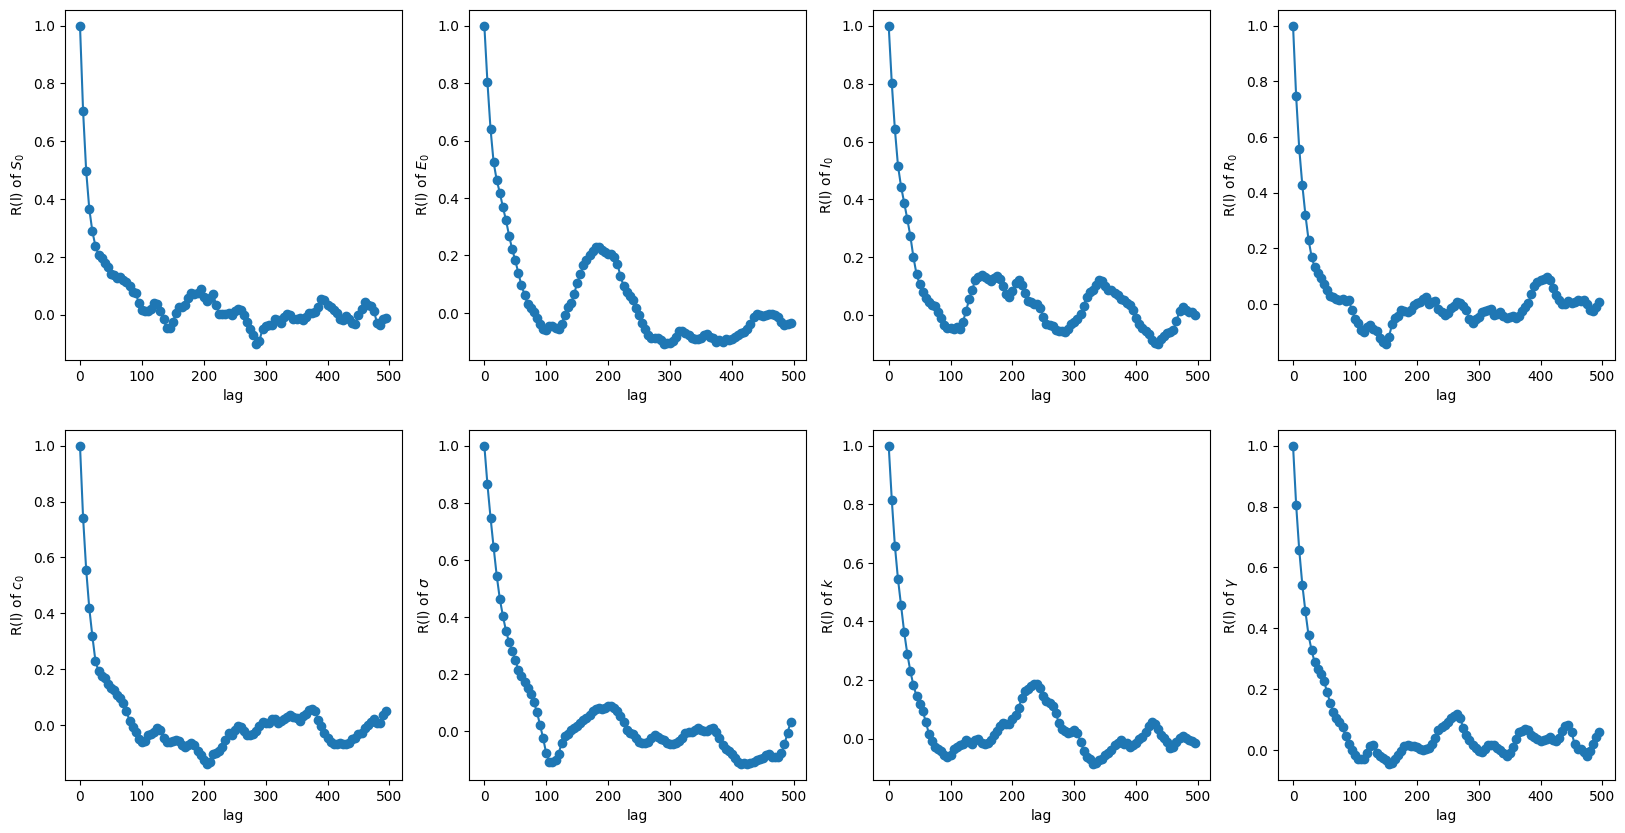

In [24]:

maxlag=500
step=5
lags, autolag = autocorrelation(sub_samples, maxlag=maxlag,step=step)

plot_autocorrelation(lags, autolag, labels=[r"$S_0$", r"$E_0$", r"$I_0$", r"$R_0$", r"$c_0$", r"$\sigma$", r"$k$", r"$\gamma$"])

In [16]:
lags_id_all, autolag_id_all = autocorrelation(sub_samples, maxlag=500, step=1)

In [18]:
def find_iac(autolag):
    num_dim = autolag.shape[1]
    
    stop_index = np.argmax(autolag<0, 0)
    stop_index[stop_index==0] = autolag.shape[0]
    print(f"Lag that reached negative: {stop_index}")
    
    iac = np.empty(num_dim)
    for ii in range(num_dim):
        iac[ii] = 1.0 + 2 * np.sum(autolag[0:stop_index[ii], ii])
    return iac

iac_identifiable = find_iac(autolag_id_all)
print(iac_identifiable)

Lag that reached negative: [132  81  83  93  84  93  69  96]
[47.13014059 52.35152491 47.95914723 37.17927542 42.31886872 66.07149732
 46.5288139  56.99550596]
